1) Find Outliers (use gaussian formula with cos)

2) Classification problem with target value: Outlier/ not Outlier

3) Classification problem before and after removal of outliers



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy.stats import multivariate_normal
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn import tree
from imblearn.combine import SMOTETomek
import pydotplus
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def oneHotFunc(df, categ):
  for i in range(len(categ)):
    one_hot = pd.get_dummies(df[categ[i]])
    names = df[categ[i]].unique()
    temp = []
    for j in range(len(names)):
      temp.append(categ[i] +'_'+ str(names[j]))
    one_hot.columns = temp
    df = df.drop(categ[i],axis = 1)
    df= df.join(one_hot)
  print(df.head())
  return df

In [ ]:
def MissingValuesHandler(df, categ, cont):
  for s in categ:
    mode = df[s].mode()[0]
    df[s] = df[s].replace("?", mode)
  for s in cont:
    temp = df[s].copy()
    temp = temp.replace("?", 0)
    temp = temp.replace('nan', 0)
    median = temp.median()
    df[s] = df[s].replace('?',median)
    df[s] = df[s].replace('nan',median)
  return df

Removing Outliers
-------------------------

Cylinder Bands
---------------

In [ ]:
colnames = ['timestamp', 'cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank',
'proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content', 'target']
df = pd.read_csv("drive/MyDrive/Datasets/bands.data",names=colnames, header=None)
df = df.drop('timestamp',1)
df.head()

cylinder number: nominal

customer: nominal;

job number: nominal;

grain screened: nominal; yes, no

ink color: nominal;  key, type

proof on ctd ink:  nominal;  yes, no  

blade mfg: nominal;  benton, daetwyler, uddeholm

cylinder division: nominal;  gallatin, warsaw, mattoon

paper type: nominal;  uncoated, coated, super

ink type: nominal;  uncoated, coated, cover

direct steam: nominal; use; yes, no *

solvent type: nominal;  xylol, lactol, naptha, line, other

type on cylinder:  nominal;  yes, no  

press type: nominal; use; 70 wood hoe, 70 motter, 70 albert, 94 motter

press: nominal;  821, 802, 813, 824, 815, 816, 827, 828

unit number: nominal;  1, 2, 3, 4, 5, 6, 7, 8, 9, 10

cylinder size: nominal;  catalog, spiegel, tabloid

paper mill location: nominal; north us, south us, canadian, scandanavian, mid european

plating tank: nominal; 1910, 1911, other

band type: nominal; class; band, no band *

In [ ]:
categ = ['cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank']
cont = ['proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content']
df = MissingValuesHandler(df, categ, cont)

In [ ]:
map = { 'band':0, 'noband':1}
df.target = [map[item] for item in df.target]

In [ ]:
df = oneHotFunc(df, categ)

In [ ]:
df = df.astype(float)
df=(df- df.mean())/df.std()
std=df.std()
df=df.transform(lambda x:-0.5*x**2)
# df = df.to_numpy()
df_new = np.cos(df)
df_new = df_new / (math.sqrt(2*math.pi))
df_new = df_new / std
a=df_new.to_numpy()
df_new['score'] = np.sum(a,axis = 1 )

In [ ]:
colnames = ['timestamp', 'cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank',
'proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content', 'target']
classify_df = pd.read_csv("drive/MyDrive/Datasets/bands.data",names=colnames, header=None)
classify_df = classify_df.drop('target', 1)
classify_df['outlier']=0

In [ ]:
colnames = ['timestamp', 'cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank',
'proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content', 'target']
original = pd.read_csv("drive/MyDrive/Datasets/bands.data",names=colnames, header=None)

In [ ]:
avg=np.mean(df_new['score'])
std=np.std(df_new['score'])
final = pd.DataFrame()
outliers = pd.DataFrame()
for i in range(df_new.shape[0]):
  if df_new['score'][i] > avg + (3*std) or df_new['score'][i] < avg - (3*std):
    outliers=outliers.append(original.iloc[i])
    classify_df['outlier'][i]=1
  else:
    final=final.append(original.iloc[i])
print(outliers.shape)

In [ ]:
print(original.shape)
print(final.shape)

In [ ]:
final.to_csv('drive/MyDrive/Datasets/AfterRemovingOutliers/band.csv', index=False)

In [ ]:
classify_df.to_csv('drive/MyDrive/Datasets/Outlier_Classification/band.csv',index=False)

Credit
---------------

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','target']
df = pd.read_csv("drive/MyDrive/Datasets/creditapproval.data",names=colnames, header=None)
df = df.drop('target', 1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0


A1:	0, 1  ('b', 'a')

A4: 0, 1, 2, 3	('u', 'y', 'l', 't')
    
A5:	0, 1, 2  ('g', 'p', 'gg')
    
A6:	0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13  ('c', 'd', 'cc', 'i', 'j', 'k', 'm', 'r', 'q', 'w', 'x', 'e', 'aa', 'ff')

A7:	0, 1, 2, 3, 4, 5, 6, 7, 8 ('v', 'h', 'bb', 'j', 'n', 'z', 'dd', 'ff', 'o')

A9:	0, 1  ('t', 'f')

A10: 0, 1  ('t', 'f')

A12:	0, 1  ('t', 'f')

A13: 0, 1, 2 ('g', 'p', 's')

target: 0, 1 ('+', '-')         (class attribute)

In [ ]:
categ=['A1','A4','A5','A6','A7','A9','A10','A12','A13']
cont=['A2','A3','A8','A11','A14','A15']
df = MissingValuesHandler(df, categ, cont)

In [ ]:
df = oneHotFunc(df, categ)

      A2     A3    A8  A11    A14  ...  A12_f  A12_t  A13_g  A13_s  A13_p
0  30.83  0.000  1.25    1  00202  ...      1      0      1      0      0
1  58.67  4.460  3.04    6  00043  ...      1      0      1      0      0
2  24.50  0.500  1.50    0  00280  ...      1      0      1      0      0
3  27.83  1.540  3.75    5  00100  ...      0      1      1      0      0
4  20.17  5.625  1.71    0  00120  ...      1      0      0      0      1

[5 rows x 46 columns]


In [ ]:
df = df.astype(float)
df=(df- df.mean())/df.std()
std=df.std()
df=df.transform(lambda x:-0.5*x**2)
# df = df.to_numpy()
df_new = np.cos(df)
df_new = df_new / (math.sqrt(2*math.pi))
df_new = df_new / std
a=df_new.to_numpy()
df_new['score'] = np.sum(a,axis = 1 )

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','target']
classify_df = pd.read_csv("drive/MyDrive/Datasets/creditapproval.data",names=colnames, header=None)
classify_df = classify_df.drop('target', 1)
classify_df['outlier']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','target']
original = pd.read_csv("drive/MyDrive/Datasets/creditapproval.data",names=colnames, header=None)

In [ ]:
avg=np.mean(df_new['score'])
std=np.std(df_new['score'])
final = pd.DataFrame()
outliers = pd.DataFrame()
for i in range(df_new.shape[0]):
  if df_new['score'][i] > avg + (3*std) or df_new['score'][i] < avg - (3*std):
    outliers=outliers.append(original.iloc[i])
    classify_df['outlier'][i]=1
  else:
    final=final.append(original.iloc[i])
print(outliers.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(4, 16)


In [ ]:
print(original.shape)
print(final.shape)

(690, 16)
(686, 16)


In [ ]:
final.to_csv('drive/MyDrive/Datasets/AfterRemovingOutliers/credit.csv', index=False)

In [ ]:
classify_df.to_csv('drive/MyDrive/Datasets/Outlier_Classification/credit.csv',index=False)

Australian
---------------

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','target']
df = pd.read_csv("drive/MyDrive/Datasets/australian.dat",delimiter=' ',names=colnames, header=None)
df = df.drop('target', 1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159


Categorical attributes:

A1:	0, 1   (a, b)

A4:	1, 2, 3  (p, g, gg)

A5:  1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14 (ff, d, i, k, j, aa, m, c, w, e, q, r, cc, x )

A6:	 1, 2, 3, 4, 5, 6, 7, 8, 9  (ff, dd, j, bb, v, n, o, h, z)

A8:	1, 0  (t, f)

A9: 1, 0	(t, f)

A11: 1, 0 (t, f)

A12: 1, 2, 3  (s, g, p)

target: 0, 1 (+, -)  (class attribute)

In [ ]:
categ = ['A1','A4','A5','A6','A8','A9','A11','A12']
df = oneHotFunc(df, categ)

      A2     A3     A7  A10  A13   A14  ...  A9_1  A11_1  A11_0  A12_2  A12_1  A12_3
0  22.08  11.46  1.585    0  100  1213  ...     0      0      1      0      1      0
1  22.67   7.00  0.165    0  160     1  ...     0      1      0      0      1      0
2  29.58   1.75  1.250    0  280     1  ...     0      0      1      0      1      0
3  21.67  11.50  0.000   11    0     1  ...     1      0      1      0      1      0
4  20.17   8.17  1.960   14   60   159  ...     1      1      0      0      1      0

[5 rows x 42 columns]


In [ ]:
df=(df- df.mean())/df.std()
std=df.std()
df=df.transform(lambda x:-0.5*x**2)
df.to_numpy()
df_new = np.cos(df)
df_new = df_new / (math.sqrt(2*math.pi))
df_new = df_new / std
a=df_new.to_numpy()
df_new['score'] = np.sum(a,axis = 1 )

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','target']
classify_df = pd.read_csv("drive/MyDrive/Datasets/australian.dat",delimiter=' ',names=colnames, header=None)
classify_df = classify_df.drop('target', 1)
classify_df['outlier']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','target']
original = pd.read_csv("drive/MyDrive/Datasets/australian.dat",delimiter=' ',names=colnames, header=None)

In [ ]:
avg=np.mean(df_new['score'])
std=np.std(df_new['score'])
final = pd.DataFrame()
outliers = pd.DataFrame()
for i in range(df_new.shape[0]):
  if df_new['score'][i] > avg + (3*std) or df_new['score'][i] < avg - (3*std):
    outliers=outliers.append(original.iloc[i])
    classify_df['outlier'][i]=1
  else:
    final=final.append(original.iloc[i])
print(outliers.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(7, 15)


In [ ]:
print(original.shape)
print(final.shape)

(690, 15)
(683, 15)


In [ ]:
final.to_csv('drive/MyDrive/Datasets/AfterRemovingOutliers/australian.csv', index=False)

In [ ]:
classify_df.to_csv('drive/MyDrive/Datasets/Outlier_Classification/australian.csv',index=False)

German
---------------

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16','A17','A18','A19','A20','target']
df = pd.read_csv("drive/MyDrive/Datasets/german.data",delimiter=' ',names=colnames, header=None)
df = df.drop('target', 1)
df.head

NameError: ignored

Categorical attributes:

A1: 0, 1, 2, 3 ('A11', 'A12', 'A14', 'A13')

A3:	0, 1, 2, 3, 4  ('A34', 'A32', 'A33', 'A30', 'A31')

A4: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ('A43', 'A46', 'A42', 'A40', 'A41', 'A49', 'A44', 'A45', 'A410',
       'A48')

A6:	 0, 1, 2, 3, 4  ('A65', 'A61', 'A63', 'A64', 'A62')

A7:	0, 1, 2, 3, 4  ('A75', 'A73', 'A74', 'A71', 'A72')

A9: 0, 1, 2, 3,	('A93', 'A92', 'A91', 'A94')

A10: 0, 1, 2 ('A101', 'A103', 'A102')

A12: 0, 1, 2, 3  ('A121', 'A122', 'A124', 'A123')

A14: 0, 1, 2 ('A143', 'A141', 'A142')

A15: 0, 1, 2 ('A152', 'A153', 'A151')

A17: 0, 1, 2, 3 ('A173', 'A172', 'A174', 'A171')

A19: 0, 1 ('A192', 'A191')

A20: 0, 1 ('A201', 'A202)

target: 1, 2

In [ ]:
categ=['A1','A3','A4','A6','A7','A9','A10','A12','A14','A15','A17','A19','A20']
df = oneHotFunc(df, categ)

   A2    A5  A8  A11  A13  ...  A17_A171  A19_A192  A19_A191  A20_A201  A20_A202
0   6  1169   4    4   67  ...         0         0         1         1         0
1  48  5951   2    2   22  ...         0         1         0         1         0
2  12  2096   2    3   49  ...         0         1         0         1         0
3  42  7882   2    4   45  ...         0         1         0         1         0
4  24  4870   3    4   53  ...         0         1         0         1         0

[5 rows x 61 columns]


In [ ]:
df=(df- df.mean())/df.std()
std=df.std()
df=df.transform(lambda x:-0.5*x**2)
df.to_numpy()
df_new = np.cos(df)
df_new = df_new / (math.sqrt(2*math.pi))
df_new = df_new / std
a=df_new.to_numpy()
df_new['score'] = np.sum(a,axis = 1 )

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16','A17','A18','A19','A20','target']
classify_df = pd.read_csv("drive/MyDrive/Datasets/german.data",delimiter=' ',names=colnames, header=None)
classify_df = classify_df.drop('target', 1)
classify_df['outlier']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16','A17','A18','A19','A20','target']
original = pd.read_csv("drive/MyDrive/Datasets/german.data",delimiter=' ',names=colnames, header=None)

In [ ]:
avg=np.mean(df_new['score'])
std=np.std(df_new['score'])
final = pd.DataFrame()
outliers = pd.DataFrame()
for i in range(df_new.shape[0]):
  if df_new['score'][i] > avg + (3*std) or df_new['score'][i] < avg - (3*std):
    outliers=outliers.append(original.iloc[i])
    classify_df['outlier'][i]=1
  else:
    final=final.append(original.iloc[i])
print(outliers.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(7, 21)


In [ ]:
print(original.shape)
print(final.shape)

(1000, 21)
(993, 21)


In [ ]:
final.to_csv('drive/MyDrive/Datasets/AfterRemovingOutliers/german.csv', index=False)

In [ ]:
classify_df.to_csv('drive/MyDrive/Datasets/Outlier_Classification/german.csv',index=False)

Heart
---------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Datasets/heart.csv")
df = df.drop('target', 1)
df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


(303, 13)

Unique values for categorical variables

sex: [1, 0]

cp: [3, 2, 1, 0]

fbs: [1, 0]

restecg: [0, 1, 2]

exang: [0, 1]

slope: [0, 2, 1]

ca: [0, 2, 1, 3, 4]

thal: [1, 2, 3, 0]



In [ ]:
categ = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
df = oneHotFunc(df,categ)

   age  trestbps  chol  thalach  oldpeak  ...  ca_4  thal_1  thal_2  thal_3  thal_0
0   63       145   233      150      2.3  ...     0       0       1       0       0
1   37       130   250      187      3.5  ...     0       0       0       1       0
2   41       130   204      172      1.4  ...     0       0       0       1       0
3   56       120   236      178      0.8  ...     0       0       0       1       0
4   57       120   354      163      0.6  ...     0       0       0       1       0

[5 rows x 30 columns]


In [ ]:
df=(df- df.mean())/df.std()
std=df.std()
df=df.transform(lambda x:-0.5*x**2)
df.to_numpy()
df_new = np.cos(df)
df_new = df_new / (math.sqrt(2*math.pi))
df_new = df_new / std
a=df_new.to_numpy()
df_new['score'] = np.sum(a,axis = 1 )

In [ ]:
classify_df= pd.read_csv('drive/MyDrive/Datasets/heart.csv')
classify_df = classify_df.drop('target', 1)
classify_df['outlier']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
original = pd.read_csv('drive/MyDrive/Datasets/heart.csv')

In [ ]:
avg=np.mean(df_new['score'])
std=np.std(df_new['score'])
final = pd.DataFrame()
outliers = pd.DataFrame()
for i in range(df_new.shape[0]):
  if df_new['score'][i] > avg + (3*std) or df_new['score'][i] < avg - (3*std):
    outliers=outliers.append(original.iloc[i])
    classify_df['outlier'][i]=1
  else:
    final=final.append(original.iloc[i])
print(outliers.shape)

(4, 14)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
print(original.shape)
print(final.shape)

(303, 14)
(299, 14)


In [ ]:
final.to_csv('drive/MyDrive/Datasets/AfterRemovingOutliers/heart.csv', index=False)

In [ ]:
classify_df.to_csv('drive/MyDrive/Datasets/Outlier_Classification/heart.csv',index=False)

Classification Problem
--------------------------------
Given sample Outlier or not

Cylinder Bands
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Datasets/Outlier_Classification/band.csv")
df.head()

,timestamp,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,...,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,outlier
0,19910108,X126,TVGUIDE,25503,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,...,36.4,0,0,2.5,1,34,40,105,100,0
1,19910109,X266,TVGUIDE,25503,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,...,38.5,0,0,2.5,0.7,34,40,105,100,0
2,19910104,B7,MODMAT,47201,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,...,39.8,0,0,2.8,0.9,40,40,103.87,100,0
3,19910104,T133,MASSEY,39039,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,...,38.8,0,0,2.5,1.3,40,40,108.06,100,0
4,19910111,J34,KMART,37351,NO,KEY,YES,BENTON,GALLATIN,UNCOATED,...,42.5,5,0,2.3,0.6,35,40,106.67,100,0


In [ ]:
categ = ['cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank']
cont = ['proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content']
df = MissingValuesHandler(df, categ, cont)

In [ ]:
df = df.drop('timestamp',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
df = oneHotFunc(df, categ)
df = df.astype(float)

  proof_cut viscosity caliper ink_temperature humifity roughness  \
0        55        46     0.2              17       78      0.75   
1        55        46     0.3              15       80      0.75   
2        62        40   0.433              16       80      0.75   
3        52        40     0.3              16       75    0.3125   
4        50        46     0.3              17       80      0.75   

  blade_pressure varnish_pct press_speed ink_pct  ... cylinder_size_tabloid  \
0             20        13.1        1700    50.5  ...                     0   
1             20         6.6        1900    54.9  ...                     0   
2             30         6.5        1850    53.8  ...                     0   
3             30         5.6        1467    55.6  ...                     0   
4             30           0        2100    57.5  ...                     0   

  cylinder_size_spiegel paper_mill_location_NorthUS  \
0                     0                           0   
1     

In [ ]:
msk = df['outlier'] == 1
num_to_oversample = len(df) - 2*msk.sum()
df_positive_oversample = df[msk].sample(n=num_to_oversample, replace=True, random_state=888)
df_train_oversample = pd.concat([df, df_positive_oversample])
df_train_oversample['outlier'].value_counts()

0.0    536
1.0    536
Name: outlier, dtype: int64

In [ ]:
X_train, X_test = train_test_split(df_train_oversample, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


Confusion Matrix:
[[156   2]
 [  0 164]]
Accuracy: 0.9937888198757764
Precision: 0.9879518072289156
Recall: 1.0
TPR:  1.0
FPR:  0.012658227848101266
F1 Score: 0.993939393939394


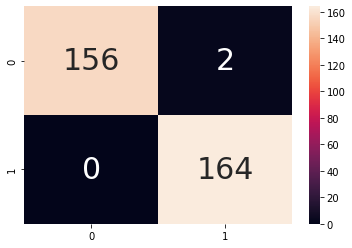

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d",annot_kws={'size': 30})
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[156   2]
 [  0 164]]
Accuracy: 0.9937888198757764
Precision: 0.9879518072289156
Recall: 1.0
TPR:  1.0
FPR:  0.012658227848101266
F1 Score: 0.993939393939394


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[156   2]
 [  0 164]]
Accuracy: 0.9937888198757764
Precision: 0.9879518072289156
Recall: 1.0
TPR:  1.0
FPR:  0.012658227848101266
F1 Score: 0.993939393939394


Credit
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Datasets/Outlier_Classification/credit.csv")
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,outlier
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,0
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,0
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,0
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,0
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,0


In [ ]:
categ=['A1','A4','A5','A6','A7','A9','A10','A12','A13']
cont=['A2','A3','A8','A11','A14','A15']
df = MissingValuesHandler(df, categ, cont)

In [ ]:
df = oneHotFunc(df,categ)
df = df.astype(float)

      A2     A3    A8  A11    A14  A15  outlier  A1_b  A1_a  A4_u  ...  A7_n  \
0  30.83  0.000  1.25    1  00202    0        0     0     1     0  ...     0   
1  58.67  4.460  3.04    6  00043  560        0     1     0     0  ...     0   
2  24.50  0.500  1.50    0  00280  824        0     1     0     0  ...     0   
3  27.83  1.540  3.75    5  00100    3        0     0     1     0  ...     0   
4  20.17  5.625  1.71    0  00120    0        0     0     1     0  ...     0   

   A9_t  A9_f  A10_t  A10_f  A12_f  A12_t  A13_g  A13_s  A13_p  
0     0     1      0      1      1      0      1      0      0  
1     0     1      0      1      1      0      1      0      0  
2     0     1      1      0      1      0      1      0      0  
3     0     1      0      1      0      1      1      0      0  
4     0     1      1      0      1      0      0      0      1  

[5 rows x 47 columns]


In [ ]:
msk = df['outlier'] == 1
num_to_oversample = len(df) - 2*msk.sum()
df_positive_oversample = df[msk].sample(n=num_to_oversample, replace=True, random_state=888)
df_train_oversample = pd.concat([df, df_positive_oversample])
df_train_oversample['outlier'].value_counts()

0.0    686
1.0    686
Name: outlier, dtype: int64

In [ ]:
X_train, X_test = train_test_split(df_train_oversample, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


Confusion Matrix:
[[210   1]
 [  0 201]]
Accuracy: 0.9975728155339806
Precision: 0.995049504950495
Recall: 1.0
TPR:  1.0
FPR:  0.004739336492890996
F1 Score: 0.9975186104218362


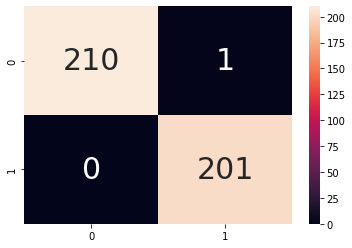

In [ ]:
# clf = DecisionTreeClassifier()
# clf = clf.fit(X_train,y_train)
# y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d",annot_kws={'size': 30})
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[210   1]
 [  0 201]]
Accuracy: 0.9975728155339806
Precision: 0.995049504950495
Recall: 1.0
TPR:  1.0
FPR:  0.004739336492890996
F1 Score: 0.9975186104218362


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[210   1]
 [  0 201]]
Accuracy: 0.9975728155339806
Precision: 0.995049504950495
Recall: 1.0
TPR:  1.0
FPR:  0.004739336492890996
F1 Score: 0.9975186104218362


Australian
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Datasets/Outlier_Classification/australian.csv")
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,outlier
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,0


In [ ]:
categ = ['A1','A4','A5','A6','A8','A9','A11','A12']
df = oneHotFunc(df, categ)

      A2     A3     A7  A10  A13   A14  outlier  A1_1  A1_0  A4_2  ...  A6_7  \
0  22.08  11.46  1.585    0  100  1213        0     0     1     0  ...     0   
1  22.67   7.00  0.165    0  160     1        0     1     0     0  ...     0   
2  29.58   1.75  1.250    0  280     1        0     1     0     1  ...     0   
3  21.67  11.50  0.000   11    0     1        0     1     0     1  ...     0   
4  20.17   8.17  1.960   14   60   159        0     0     1     0  ...     0   

   A8_0  A8_1  A9_0  A9_1  A11_1  A11_0  A12_2  A12_1  A12_3  
0     1     0     1     0      0      1      0      1      0  
1     1     0     1     0      1      0      0      1      0  
2     1     0     1     0      0      1      0      1      0  
3     0     1     0     1      0      1      0      1      0  
4     0     1     0     1      1      0      0      1      0  

[5 rows x 43 columns]


In [ ]:
msk = df['outlier'] == 1
num_to_oversample = len(df) - 2*msk.sum()
df_positive_oversample = df[msk].sample(n=num_to_oversample, replace=True, random_state=888)
df_train_oversample = pd.concat([df, df_positive_oversample])
df_train_oversample['outlier'].value_counts()

0    683
1    683
Name: outlier, dtype: int64

In [ ]:
X_train, X_test = train_test_split(df_train_oversample, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


Confusion Matrix:
[[208   5]
 [  0 197]]
Accuracy: 0.9878048780487805
Precision: 0.9752475247524752
Recall: 1.0
TPR:  1.0
FPR:  0.023474178403755867
F1 Score: 0.9874686716791979


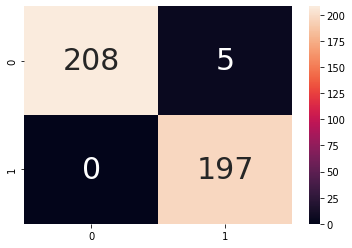

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d",annot_kws={'size': 30})
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[212   1]
 [  0 197]]
Accuracy: 0.9975609756097561
Precision: 0.9949494949494949
Recall: 1.0
TPR:  1.0
FPR:  0.004694835680751174
F1 Score: 0.9974683544303797


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[212   1]
 [  0 197]]
Accuracy: 0.9975609756097561
Precision: 0.9949494949494949
Recall: 1.0
TPR:  1.0
FPR:  0.004694835680751174
F1 Score: 0.9974683544303797


German
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Datasets/Outlier_Classification/german.csv")
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A12,A13,A14,A15,A16,A17,A18,A19,A20,outlier
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [ ]:
categ=['A1','A3','A4','A6','A7','A9','A10','A12','A14','A15','A17','A19','A20']
df = oneHotFunc(df, categ)

   A2    A5  A8  A11  A13  A16  A18  outlier  A1_A11  A1_A12  ...  A15_A153  \
0   6  1169   4    4   67    2    1        0       1       0  ...         1   
1  48  5951   2    2   22    1    1        0       0       1  ...         1   
2  12  2096   2    3   49    1    2        0       0       0  ...         1   
3  42  7882   2    4   45    1    2        0       1       0  ...         0   
4  24  4870   3    4   53    2    2        0       1       0  ...         0   

   A15_A151  A17_A173  A17_A172  A17_A174  A17_A171  A19_A192  A19_A191  \
0         0         0         0         1         0         0         1   
1         0         0         0         1         0         1         0   
2         0         0         1         0         0         1         0   
3         1         0         0         1         0         1         0   
4         1         0         0         1         0         1         0   

   A20_A201  A20_A202  
0         1         0  
1         1         0  
2 

In [ ]:
msk = df['outlier'] == 1
num_to_oversample = len(df) - 2*msk.sum()
df_positive_oversample = df[msk].sample(n=num_to_oversample, replace=True, random_state=888)
df_train_oversample = pd.concat([df, df_positive_oversample])
df_train_oversample['outlier'].value_counts()

0    993
1    993
Name: outlier, dtype: int64

In [ ]:
X_train, X_test = train_test_split(df_train_oversample, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


Confusion Matrix:
[[295   1]
 [  0 300]]
Accuracy: 0.9983221476510067
Precision: 0.9966777408637874
Recall: 1.0
TPR:  1.0
FPR:  0.0033783783783783786
F1 Score: 0.9983361064891847


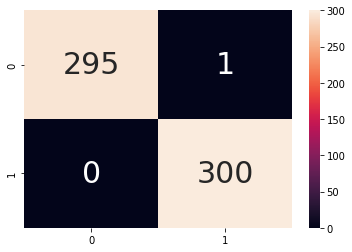

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d",annot_kws={'size': 30})
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[294   2]
 [  0 300]]
Accuracy: 0.9966442953020134
Precision: 0.9933774834437086
Recall: 1.0
TPR:  1.0
FPR:  0.006756756756756757
F1 Score: 0.9966777408637874


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[294   2]
 [  0 300]]
Accuracy: 0.9966442953020134
Precision: 0.9933774834437086
Recall: 1.0
TPR:  1.0
FPR:  0.006756756756756757
F1 Score: 0.9966777408637874


Heart
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Datasets/Outlier_Classification/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,outlier
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


In [ ]:
categ = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
df = oneHotFunc(df, categ)

   age  trestbps  chol  thalach  oldpeak  outlier  sex_1  sex_0  cp_3  cp_2  \
0   63       145   233      150      2.3        0      0      1     0     0   
1   37       130   250      187      3.5        0      0      1     0     0   
2   41       130   204      172      1.4        0      1      0     0     1   
3   56       120   236      178      0.8        0      0      1     0     1   
4   57       120   354      163      0.6        0      1      0     1     0   

   ...  slope_1  ca_0  ca_2  ca_1  ca_3  ca_4  thal_1  thal_2  thal_3  thal_0  
0  ...        0     1     0     0     0     0       0       1       0       0  
1  ...        0     1     0     0     0     0       0       0       1       0  
2  ...        1     1     0     0     0     0       0       0       1       0  
3  ...        1     1     0     0     0     0       0       0       1       0  
4  ...        1     1     0     0     0     0       0       0       1       0  

[5 rows x 31 columns]


In [ ]:
msk = df['outlier'] == 1
num_to_oversample = len(df) - 2*msk.sum()
df_positive_oversample = df[msk].sample(n=num_to_oversample, replace=True, random_state=888)
df_train_oversample = pd.concat([df, df_positive_oversample])
df_train_oversample['outlier'].value_counts()

0    299
1    299
Name: outlier, dtype: int64

In [ ]:
X_train, X_test = train_test_split(df_train_oversample, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


Confusion Matrix:
[[87  0]
 [ 0 93]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
TPR:  1.0
FPR:  0.0
F1 Score: 1.0


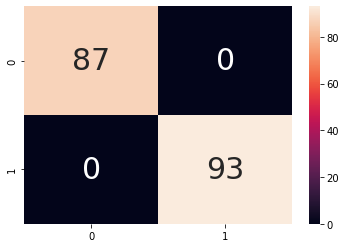

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d",annot_kws={'size': 30})
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[87  0]
 [ 0 93]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
TPR:  1.0
FPR:  0.0
F1 Score: 1.0


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[87  0]
 [ 0 93]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
TPR:  1.0
FPR:  0.0
F1 Score: 1.0


Classification
-----------------------------
Before and after removing Outliers: using Random Forest

Cylinder Bands
-------------

In [ ]:
df_after=pd.read_csv("drive/MyDrive/Datasets/AfterRemovingOutliers/band.csv")
colnames = ['timestamp', 'cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank',
'proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content', 'target']
df_before = pd.read_csv("drive/MyDrive/Datasets/bands.data",names=colnames, header=None)

In [ ]:
categ = ['cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank']
cont = ['proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content']
df_before = MissingValuesHandler(df_before, categ, cont)
df_after = MissingValuesHandler(df_after, categ, cont)

In [ ]:
df_before = oneHotFunc(df_before, categ)
df_after = oneHotFunc(df_after, categ)

   timestamp proof_cut viscosity caliper ink_temperature humifity roughness  \
0   19910108        55        46     0.2              17       78      0.75   
1   19910109        55        46     0.3              15       80      0.75   
2   19910104        62        40   0.433              16       80      0.75   
3   19910104        52        40     0.3              16       75    0.3125   
4   19910111        50        46     0.3              17       80      0.75   

  blade_pressure varnish_pct press_speed  ... cylinder_size_tabloid  \
0             20        13.1        1700  ...                     0   
1             20         6.6        1900  ...                     0   
2             30         6.5        1850  ...                     0   
3             30         5.6        1467  ...                     0   
4             30           0        2100  ...                     0   

  cylinder_size_spiegel paper_mill_location_NorthUS  \
0                     0                    

In [ ]:
map = { 'band':0, 'noband':1}
df_before.target = [map[item] for item in df_before.target]
df_after.target = [map[item] for item in df_after.target]
df_before = df_before.astype(float)
df_after = df_after.astype(float)

In [ ]:
df_before = df_before.drop('timestamp',1)
df_after = df_after.drop('timestamp',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
X = df_before.drop('target',1)
y = df_before['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=5)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[43 23]
 [10 86]]
Accuracy: 0.7962962962962963
Precision: 0.7889908256880734
Recall: 0.8958333333333334
TPR:  0.8958333333333334
FPR:  0.3484848484848485
F1 Score: 0.8390243902439025


In [ ]:
X = df_after.drop('target',1)
y = df_after['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=5)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[45 22]
 [ 9 85]]
Accuracy: 0.8074534161490683
Precision: 0.794392523364486
Recall: 0.9042553191489362
TPR:  0.9042553191489362
FPR:  0.3283582089552239
F1 Score: 0.845771144278607


Credit
-------------

In [ ]:
df_after=pd.read_csv("drive/MyDrive/Datasets/AfterRemovingOutliers/credit.csv")
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','target']
df_before = pd.read_csv("drive/MyDrive/Datasets/creditapproval.data",names=colnames, header=None)

In [ ]:
categ=['A1','A4','A5','A6','A7','A9','A10','A12','A13']
cont=['A2','A3','A8','A11','A14','A15']
df_before = MissingValuesHandler(df_before, categ, cont)
df_after = MissingValuesHandler(df_after, categ, cont)

In [ ]:
df_before = oneHotFunc(df_before, categ)
df_after = oneHotFunc(df_after, categ)

      A2     A3    A8  A11    A14  A15 target  A1_b  A1_a  A4_u  ...  A7_n  \
0  30.83  0.000  1.25    1  00202    0      +     0     1     0  ...     0   
1  58.67  4.460  3.04    6  00043  560      +     1     0     0  ...     0   
2  24.50  0.500  1.50    0  00280  824      +     1     0     0  ...     0   
3  27.83  1.540  3.75    5  00100    3      +     0     1     0  ...     0   
4  20.17  5.625  1.71    0  00120    0      +     0     1     0  ...     0   

   A9_t  A9_f  A10_t  A10_f  A12_f  A12_t  A13_g  A13_s  A13_p  
0     0     1      0      1      1      0      1      0      0  
1     0     1      0      1      1      0      1      0      0  
2     0     1      1      0      1      0      1      0      0  
3     0     1      0      1      0      1      1      0      0  
4     0     1      1      0      1      0      0      0      1  

[5 rows x 47 columns]
      A2     A3    A8  A11    A14    A15 target  A1_b  A1_a  A4_u  ...  A7_n  \
0  30.83  0.000  1.25  1.0  00202    0

In [ ]:
map = { '+':0, '-':1}
df_before.target = [map[item] for item in df_before.target]
df_after.target = [map[item] for item in df_after.target]
df_before = df_before.astype(float)
df_after = df_after.astype(float)

In [ ]:
X = df_before.drop('target',1)
y = df_before['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=5)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[ 72  18]
 [ 12 105]]
Accuracy: 0.855072463768116
Precision: 0.8536585365853658
Recall: 0.8974358974358975
TPR:  0.8974358974358975
FPR:  0.2
F1 Score: 0.875


In [ ]:
X = df_after.drop('target',1)
y = df_after['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=10)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[86  7]
 [14 99]]
Accuracy: 0.8980582524271845
Precision: 0.9339622641509434
Recall: 0.8761061946902655
TPR:  0.8761061946902655
FPR:  0.07526881720430108
F1 Score: 0.904109589041096


Australian
-------------

In [ ]:
df_after=pd.read_csv("drive/MyDrive/Datasets/AfterRemovingOutliers/australian.csv")
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','target']
df_before = pd.read_csv("drive/MyDrive/Datasets/australian.dat",delimiter=' ',names=colnames, header=None)

In [ ]:
categ = ['A1','A4','A5','A6','A8','A9','A11','A12']
df_after = oneHotFunc(df_after, categ)
df_before = oneHotFunc(df_before, categ)

      A2     A3     A7   A10    A13     A14  target  A1_1.0  A1_0.0  A4_2.0  \
0  22.08  11.46  1.585   0.0  100.0  1213.0     0.0       0       1       0   
1  22.67   7.00  0.165   0.0  160.0     1.0     0.0       1       0       0   
2  29.58   1.75  1.250   0.0  280.0     1.0     0.0       1       0       1   
3  21.67  11.50  0.000  11.0    0.0     1.0     1.0       1       0       1   
4  20.17   8.17  1.960  14.0   60.0   159.0     1.0       0       1       0   

   ...  A6_7.0  A8_0.0  A8_1.0  A9_0.0  A9_1.0  A11_1.0  A11_0.0  A12_2.0  \
0  ...       0       1       0       1       0        0        1        0   
1  ...       0       1       0       1       0        1        0        0   
2  ...       0       1       0       1       0        0        1        0   
3  ...       0       0       1       0       1        0        1        0   
4  ...       0       0       1       0       1        1        0        0   

   A12_1.0  A12_3.0  
0        1        0  
1        1        

In [ ]:
X = df_before.drop('target',1)
y = df_before['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=50)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[103  17]
 [ 18  69]]
Accuracy: 0.8309178743961353
Precision: 0.8023255813953488
Recall: 0.7931034482758621
TPR:  0.7931034482758621
FPR:  0.14166666666666666
F1 Score: 0.7976878612716762


In [ ]:
X = df_after.drop('target',1)
y = df_after['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=50)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[106  13]
 [ 12  74]]
Accuracy: 0.8780487804878049
Precision: 0.8505747126436781
Recall: 0.8604651162790697
TPR:  0.8604651162790697
FPR:  0.1092436974789916
F1 Score: 0.8554913294797688


German
-------------

In [ ]:
df_after=pd.read_csv("drive/MyDrive/Datasets/AfterRemovingOutliers/german.csv")
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16','A17','A18','A19','A20','target']
df_before = pd.read_csv("drive/MyDrive/Datasets/german.data",delimiter=' ',names=colnames, header=None)

In [ ]:
categ=['A1','A3','A4','A6','A7','A9','A10','A12','A14','A15','A17','A19','A20']
df_before = oneHotFunc(df_before, categ)
df_after = oneHotFunc(df_after, categ)

   A2    A5  A8  A11  A13  A16  A18  target  A1_A11  A1_A12  ...  A15_A153  \
0   6  1169   4    4   67    2    1       1       1       0  ...         1   
1  48  5951   2    2   22    1    1       2       0       1  ...         1   
2  12  2096   2    3   49    1    2       1       0       0  ...         1   
3  42  7882   2    4   45    1    2       1       1       0  ...         0   
4  24  4870   3    4   53    2    2       2       1       0  ...         0   

   A15_A151  A17_A173  A17_A172  A17_A174  A17_A171  A19_A192  A19_A191  \
0         0         0         0         1         0         0         1   
1         0         0         0         1         0         1         0   
2         0         0         1         0         0         1         0   
3         1         0         0         1         0         1         0   
4         1         0         0         1         0         1         0   

   A20_A201  A20_A202  
0         1         0  
1         1         0  
2       

In [ ]:
X = df_before.drop('target',1)
y = df_before['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=10)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[189  14]
 [ 64  33]]
Accuracy: 0.74
Precision: 0.7470355731225297
Recall: 0.9310344827586207
TPR:  0.3402061855670103
FPR:  0.06896551724137931
F1 Score: 0.8289473684210527


In [ ]:
X = df_after.drop('target',1)
y = df_after['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[201  14]
 [ 57  26]]
Accuracy: 0.761744966442953
Precision: 0.7790697674418605
Recall: 0.9348837209302325
TPR:  0.3132530120481928
FPR:  0.06511627906976744
F1 Score: 0.849894291754757


Heart
-------------

In [ ]:
df_after=pd.read_csv("drive/MyDrive/Datasets/AfterRemovingOutliers/heart.csv")
df_before=pd.read_csv("drive/MyDrive/Datasets/heart.csv")

In [ ]:
categ = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
df_after = oneHotFunc(df_after, categ)
df_before = oneHotFunc(df_before, categ)

    age  trestbps   chol  thalach  oldpeak  target  sex_1.0  sex_0.0  cp_3.0  \
0  63.0     145.0  233.0    150.0      2.3     1.0        0        1       0   
1  37.0     130.0  250.0    187.0      3.5     1.0        0        1       0   
2  41.0     130.0  204.0    172.0      1.4     1.0        1        0       0   
3  56.0     120.0  236.0    178.0      0.8     1.0        0        1       0   
4  57.0     120.0  354.0    163.0      0.6     1.0        1        0       1   

   cp_2.0  ...  slope_1.0  ca_0.0  ca_2.0  ca_1.0  ca_3.0  ca_4.0  thal_1.0  \
0       0  ...          0       1       0       0       0       0         0   
1       0  ...          0       1       0       0       0       0         0   
2       1  ...          1       1       0       0       0       0         0   
3       1  ...          1       1       0       0       0       0         0   
4       0  ...          1       1       0       0       0       0         0   

   thal_2.0  thal_3.0  thal_0.0  
0         

In [ ]:
X = df_before.drop('target',1)
y = df_before['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=50)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[30  9]
 [ 9 43]]
Accuracy: 0.8021978021978022
Precision: 0.8269230769230769
Recall: 0.8269230769230769
TPR:  0.8269230769230769
FPR:  0.23076923076923078
F1 Score: 0.8269230769230769


In [ ]:
X = df_after.drop('target',1)
y = df_after['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=25)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy after removal:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[32  6]
 [ 7 45]]
Accuracy after removal: 0.8555555555555555
Precision: 0.8823529411764706
Recall: 0.8653846153846154
F1 Score: 0.8737864077669903
